# Notebook for solving the movement of water and heat through unsaturated porous medium 
## Belowground solver of coupled soil moisture and soil temperature state variables
### Dev versionfor CLiMA land surface model component
### Author: Debsunder Dutta @ Caltech

In [1]:
# Set The PATH Here!
push!(LOAD_PATH, "/Users/debsunderdutta/Dropbox/JULIA_Research/Soil_Moisture_Heat_Model/")
# Include required libraries
using Plots
using Parameters
using Printf
using Soil_Physics

# 1-D Transient Heat Equation Solver
# $\frac{\partial T}{\partial t}=\frac{\kappa}{c_{v}} \frac{\partial^{2} T}{\partial z^{2}}$

For the solution we use a Finite Difference Scheme and more specifically an implicit time discretization is used where the spatial derivatives are written using a central difference scheme at time n+1 and a backward time difference approximation at time n+1.
The computational grid is as follows:
<img src="Compute_Grid.png" style="width:400px;"/>
The finite difference approximation of the $T$ is as follows:
$$
\begin{aligned}
-& \frac{\kappa_{i-1 / 2}}{\Delta z_{i-1 / 2}} T_{i-1}^{n+1}+\left(\frac{c_{v, i} \Delta z_{i}}{\Delta t}+\frac{\kappa_{i-1 / 2}}{\Delta z_{i-1 / 2}}+\frac{\kappa_{i+1 / 2}}{\Delta z_{i+1 / 2}}\right) T_{i}^{n+1} -\frac{\kappa_{i+1 / 2}}{\Delta z_{i+1 / 2}} T_{i+1}^{n+1}=\frac{c_{v, i} \Delta z_{i}}{\Delta t} T_{i}^{n}
\end{aligned}
$$

Boundary Conditions:
we specify $T_0^{n+1}$ at the top     (Dirichlet Boundary)

Zero Flux at bottom $F_{N}^{n+1}=0$ (Neumann Boundary)

Numerical Method used: Implicit Method.
The general form of the tridiagonal system of equations is:

$$
a_{i} T_{i-1}^{n+1}+b_{i} T_{i}^{n+1}+c_{i} T_{i+1}^{n+1}=d_{i}
$$

In [2]:
# Defining the soil heat methods and grids UNITS are Important
global physcon = Soil_Physics.physcon() # Define the number of soil Layers
global soilvar = Soil_Physics.soilvar(nsoi=150)
# Generate the Soil Compute Grid
soilvar = Soil_Physics.compute_grid_settings_heat(soilvar)

# --- Model run control parameters

tmean = physcon.tfrz + 15.0;       # Mean daily air temperature for diurnal cycle [K]
trange = 30.0;                     # Temperature range for diurnal cycle [K]
dt = 1800;                         # Time step [seconds]
nday = 100;                        # Number of days
soilvar.soil_texture = 1;          # Soil texture class: sand
soilvar.method = "excess-heat";    # Use excess heat for phase change

#soilvar.soil_texture = 11;         # Soil texture class: clay
#soilvar.method = "apparent-heat-capacity"; # Use apparent heat capacity for phase change

In [3]:
# Initial soil temperature [K] and unfrozen & frozen water [kg H2O/m2]

for i = 1:soilvar.nsoi

   # Temperature [K]

   soilvar.tsoi[i] = physcon.tfrz + 2.0

   # Soil water at saturation [kg H2O/m2]

   h2osoi_sat = soilvar.watsat[soilvar.soil_texture] * physcon.rhowat * soilvar.dz[i]

   # Actual water content is some fraction of saturation

   if (soilvar.tsoi[i] .> physcon.tfrz)
      soilvar.h2osoi_ice[i] = 0
      soilvar.h2osoi_liq[i] = 0.8 * h2osoi_sat
   else()
      soilvar.h2osoi_liq[i] = 0
      soilvar.h2osoi_ice[i] = 0.8 * h2osoi_sat
   end

end


In [4]:
# ---  SPIN UP OF SOIL TEMPERATURE to see the diurnal cycle

# Main loop is NTIM iterations per day with a time step of DT seconds.
# This is repeated NDAY times.

ntim = round(86400/dt)

hour_vec = Float64[]
z_vec = Float64[]
tsoi_vec = Float64[]


temp=soilvar.z
idx=temp.>-1 # First 1m or 100cm
temp1=temp[idx]

hour_out = zeros(Int(ntim))
z_out    = zeros(length(temp1)+1)
tsoi_out = zeros(length(temp1)+1,Int(ntim))

for iday = 1:nday
   @printf("day = %6.0f\n",iday)
   for itim = 1:ntim

      # Hour of day

      hour = itim * (dt/86400 * 24)

      # Surface temperature: Constant value TMEAN if TRANGE = 0. Otherwise; use a sine
      # wave with max (TMEAN + 1/2 TRANGE) at 2 pm & min (TMEAN - 1/2 TRANGE) at 2 am

      tsurf = tmean + 0.5 * trange * sin(2*pi/24 * (hour-8.0))

     # Thermal conductivity & heat capacity

      soilvar = soil_thermal_properties(physcon, soilvar)

      # Soil temperatures

      soilvar = soil_temperature(physcon, soilvar, tsurf, dt)

   end
end

day =      1
day =      2
day =      3
day =      4
day =      5
day =      6
day =      7
day =      8
day =      9
day =     10
day =     11
day =     12
day =     13
day =     14
day =     15
day =     16
day =     17
day =     18
day =     19
day =     20
day =     21
day =     22
day =     23
day =     24
day =     25
day =     26
day =     27
day =     28
day =     29
day =     30
day =     31
day =     32
day =     33
day =     34
day =     35
day =     36
day =     37
day =     38
day =     39
day =     40
day =     41
day =     42
day =     43
day =     44
day =     45
day =     46
day =     47
day =     48
day =     49
day =     50
day =     51
day =     52
day =     53
day =     54
day =     55
day =     56
day =     57
day =     58
day =     59
day =     60
day =     61
day =     62
day =     63
day =     64
day =     65
day =     66
day =     67
day =     68
day =     69
day =     70
day =     71
day =     72
day =     73
day =     74
day =     75
day =     76
day =     77

# Richard's Equation Solver
$$
\frac{\partial \theta}{\partial t}=\frac{\partial}{\partial z}\left[K(\theta) \frac{\partial \psi}{\partial z}\right]+\frac{\partial K}{\partial z}
$$

We will solve the head based form here:
$$
C(\psi) \frac{\partial \psi}{\partial t}=\frac{\partial}{\partial z}\left[K(\theta) \frac{\partial \psi}{\partial z}\right]+\frac{\partial K}{\partial z}
$$
For the solution we use a Finite Difference Scheme and more specifically an implicit time discretization is used where the spatial derivatives are written using a central difference scheme at time n+1 and a backward time difference approximation at time n+1.
The computational grid is as follows:
<img src="Compute_grid.png" style="width:400px;"/>
The finite difference approximation of the $\psi$ based form is as follows:
$$
\begin{array}{l}{-\frac{K_{i-1 / 2}^{n+1}}{\Delta z_{i-1 / 2}} \psi_{i-1}^{n+1}+\left(\frac{C_{i}^{n+1} \Delta z_{i}}{\Delta t}+\frac{K_{i-1 / 2}^{n+1}}{\Delta z_{i-1 / 2}}+\frac{K_{i+1 / 2}^{n+1}}{\Delta z_{i+1 / 2}}\right) \psi_{i}^{n+1}} \\ {-\frac{K_{i+1 / 2}^{n+1}}{\Delta z_{i+1 / 2}} \psi_{i+1}^{n+1}=\frac{C_{i}^{n+1} \Delta z_{i}}{\Delta t} \psi_{i}^{n}+K_{i-1 / 2}^{n+1}-K_{i+1 / 2}^{n+1}}\end{array}
$$

Boundary Conditions:
we specify $\psi_0$ at the top     (Dirichlet Boundary)

Free Drainage at bottom $Q_N=-K_N$ (Neumann Boundary)

Numerical Method used: Predictor Corrector - solves Richards equation twice. The predictor step is used to solve for $\psi$ over $(\Delta t/2)$ using K and C from time n, the Corrector step uses these to obtain $\psi$ over the full time step n.
The general form of the tridiagonal system of equations is:

$$
a_{i} \psi_{i-1}^{n+1}+b_{i} \psi_{i}^{n+1}+c_{i} \psi_{i+1}^{n+1}=d_{i}
$$

$$
\left[\begin{array}{cccccc}{b_{1}} & {c_{1}} & {0} & {0} & {0} & {0} \\ {a_{2}} & {b_{2}} & {c_{2}} & {0} & {0} & {0} \\ {0} & {a_{3}} & {b_{3}} & {c_{3}} & {0} & {0} \\ {0} & {0} & {\ddots} & {\ddots} & {\ddots} & {0} \\ {0} & {0} & {0} & {a_{N-1}} & {b_{N-1}} & {c_{N-1}} \\ {0} & {0} & {0} & {0} & {a_{N}} & {b_{N}}\end{array}\right] \times\left[\begin{array}{c}{\psi_{1}^{n+1}} \\ {\psi_{2}^{n+1}} \\ {\psi_{3}^{n+1}} \\ {\vdots} \\ {\psi_{N-1}^{n+1}} \\ {\psi_{N}^{n+1}}\end{array}\right]=\left[\begin{array}{c}{d_{1}} \\ {d_{2}} \\ {d_{3}} \\ {\vdots} \\ {d_{N-1}} \\ {d_{N}}\end{array}\right]
$$

### $\theta-\psi$ and $K-\theta$ soil constitutive relationships
### The Campbell (1974) relationships are given by:
### $\frac{\theta}{\theta_{\text {sat}}}=\left(\frac{\psi}{\psi_{\text {sat}}}\right)^{-1 / b}
$;   $K=K_{\text { sat }}\left(\frac{\theta}{\theta_{\text { sat }}}\right)^{2 b+3}$;  $\frac{d \theta}{d \psi}=\frac{-\theta_{s a t}}{b \psi_{s a t}}\left(\frac{\psi}{\psi_{s a t}}\right)^{-1/b-1}$

### The van Genuchten (1980) relationships are given by:
### $S_{\mathrm{e}}=\frac{\theta-\theta_{\mathrm{res}}}{\theta_{\mathrm{sat}}-\theta_{\mathrm{res}}}=\left[\left|+(\alpha|\psi|)^{n}\right]^{-m}\right.$;  $m=1-1 / n$;
### $\mathrm{K}=K_{\text { sat }} S_{\mathrm{e}}^{1 / 2}\left[1-\left(1-S_{\mathrm{e}}^{1 / m}\right)^{m}\right]^{2}$;  $\frac{\mathrm{d} \theta}{d \psi}=\frac{\alpha m n\left(\theta_{\text {sat}}-\theta_{\text { res }}\right)(\alpha|\psi|)^{n-1}}{\left[ 1+(\alpha|\psi|)^{n}\right]^{m+1}}$

In [5]:
# ---------------------------------------------------------------------
# Use the predictor-corrector method to solve the Richards equation for
# infiltration with surface soil moisture as the boundary condition.
# ---------------------------------------------------------------------

global soil = Soil_Physics.soil_struct(nsoi=150) # Define the number of soil Layers

# Generate the Soil Compute Grid
soil = Soil_Physics.compute_grid_settings(soil)

# --- Soil parameters Settings
soil.ssflag    = 0                 # Flag for Sink term
soil.functions = "van_Genuchten";  # Use van Genuchten relationships
#soil.functions = "Campbell";      # Use Campbell relationships

if soil.functions == "Campbell"

   # example from Hornberger & Wiberg [2005, Fig. 8.3]
   ityp = 0;              # Soil texture flag
   theta_sat = 0.25;      # Volumetric water content at saturation
   psi_sat = -25.0;       # Matric potential at saturation [cm]
   bc = 0.2;              # Exponent
   Ksat = 3.4e-03;        # Hydraulic conductivity at saturation [cm/s]
   params = [theta_sat psi_sat bc Ksat ityp]

elseif soil.functions == "van_Genuchten"

   # Haverkamp et al. (1977): sand
   ityp = 1;              # Soil texture flag
   theta_res = 0.075;     # Residual water content
   theta_sat = 0.287;     # Volumetric water content at saturation
   vg_alpha = 0.027;      # Inverse of the air entry potential [/cm]
   vg_n = 3.96;           # Pore-size distribution index
   vg_m = 1;              # Exponent
   Ksat = 34 / 3600;      # Hydraulic conductivity at saturation [cm/s]

#  # Haverkamp et al. (1977): Yolo light clay
#  ityp = 2;              # Soil texture flag
#  theta_res = 0.124;     # Residual water content
#  theta_sat = 0.495;     # Volumetric water content at saturation
#  vg_alpha = 0.026;      # Inverse of the air entry potential [/cm]
#  vg_n = 1.43;           # Pore-size distribution index
#  vg_m = 1 - 1 / vg_n;   # Exponent
#  Ksat = 0.0443 / 3600;  # Hydraulic conductivity at saturation [cm/s]

   params = [theta_res theta_sat vg_alpha vg_n vg_m Ksat ityp]
end

# --- Initial soil moisture & matric potential
for i = 1:soil.nsoi
   if (ityp == 0)
      soil.theta[i] = 0.10
   elseif ityp == 1
      soil.theta[i] = 0.10
   elseif ityp == 2
      soil.theta[i] = 0.24
   end
   soil.psi[i] = matric_potential(soil.functions, params, soil.theta[i])
end

global thetaini = copy(soil.theta)

# --- Surface boundary condition: saturation [minus some small delta]

soil.theta0 = theta_sat - 1.0e-03
if (ityp == 1)
   soil.theta0 = 0.267
end
soil.psi0 = matric_potential(soil.functions, params, soil.theta0)

# --- Time step [seconds]

dt = 10
if (ityp == 1)
   dt = 5
end

# --- Length of simulation [number of time steps]

# Hornberger & Wiberg: 15; 30; | 60 minutes
if (ityp == 0)
   ntim = 60 * 60 / dt
end

# Haverkamp et al. (1977) - sand: duration is in hours
if (ityp == 1)
  ntim = 0.8 * 3600 / dt
end

# Haverkamp et al. (1977) - Yolo light clay: duration is in seconds
if (ityp == 2)
   ntim = 1.0e6 / dt
end


# --- Initialize accumulators for water balance check
global sum_in    = 0
global sum_out   = 0
global sum_store = 0

global ET = 0.006


0.006

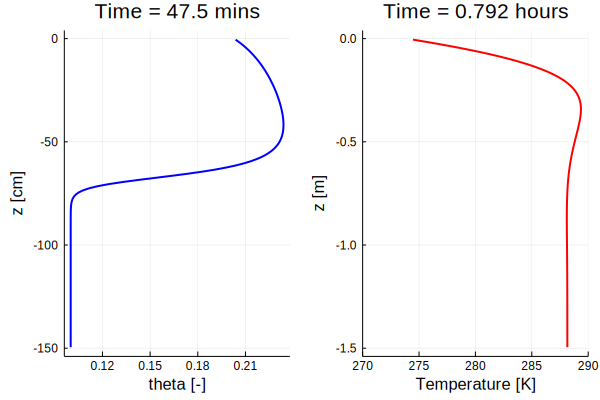

hour =    0.793 
hour =    0.794 
hour =    0.796 
hour =    0.797 
hour =    0.799 
hour =    0.800 


In [6]:
# --- Time stepping loop: NTIM iterations with a time step of DT seconds
# Solves now for both moisture and Temperature
# Initialize cumulative infiltration variables
xout = zeros(Int64.(ntim))
yout = zeros(Int64.(ntim))

for itim = 1:Int64.(ntim)

   # Hour of day
   hour = itim * (dt/86400 * 24)
   @printf("hour = %8.3f \n",hour)
    
   # Add for fun variable Boundary Condition SURFACE DRYING
    if itim > 100
        soil.theta0 = theta_sat - 1.0e-03
        if (ityp == 1)
           soil.theta0 = 0.267 - (itim-200)*0.1/ntim
        end
        soil.psi0 = matric_potential(soil.functions, params, soil.theta0)
    end


   # Calculate soil moisture
   soil = predictor_corrector(soil, params, ET, dt)
    
    # Update the soil moisure at each soil layer for the heat model
    for i = 1:soilvar.nsoi
        # Soil water at saturation [kg H2O/m2] UNITS are IMPORTANT
        soilwatercurr = soil.theta[i] * physcon.rhowat * soilvar.dz[i]
        
        # Actual water content destrinuted as liquid and ice fractions
        if (soilvar.tsoi[i] .> physcon.tfrz)
          soilvar.h2osoi_ice[i] = 0
          soilvar.h2osoi_liq[i] = soilwatercurr
        else()
          soilvar.h2osoi_liq[i] = 0
          soilvar.h2osoi_ice[i] = soilwatercurr
        end

    end
    
    # Compute updated Thermal conductivity & heat capacity
    
    soilvar = soil_thermal_properties(physcon, soilvar)

    # Update Soil temperatures
    
    tsurf = tmean + 0.5 * trange * sin(2*pi/24 * (hour-8.0)) # Surface temperature as sinusoidal function
    soilvar = soil_temperature(physcon, soilvar, tsurf, dt)
    
    # Sum fluxes for relative mass balance error()

    sum_in = sum_in + abs(soil.Q0) * dt
    sum_out = sum_out + abs(soil.QN) * dt
    sum_store = sum_store + soil.dtheta

    # Make some plots   
    if itim%10 == 0
        IJulia.clear_output(true)
        p1=plot(soil.theta,soil.z, color="blue",line=2,xlabel = "theta [-]",ylabel = "z [cm]",title="Time = "*string(round(hour*60,digits=2))*" mins")
        p2=plot(soilvar.tsoi,soilvar.z, xlim=(270,290), color="red",line=2,xlabel = "Temperature [K]",ylabel = "z [m]",title="Time = "*string(round(hour,digits=3))*" hours")
            Plots.display(plot(p1,p2,layout=(1,2),legend=false))
        sleep(0.2)
    end
        
    #print(soil.sink)

    # cumulative infiltration
    xout[itim] = hour
    yout[itim] = sum_in

end